In [1]:
# from https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
import IPython.core.display as di
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code on/off</button>''', raw=True)

# Data processing overview

This notebook:
- introduces what the data looks like 
- plots what features look like for pre-, during-, post-summiting, and alive flies in all collected experiments
- explains how motion data is converted to standardized representation for classification


### Overview

Say we have some frame of the tracking data and we want to identify flies that will succumb to the fungus. There are a few features of interest:
- local time (e.g. summiting consistently occurs a few hours post sunrise),
- current and previous behavior (e.g. infected flies tend to be low in the chamber near the food, then show a flurry of activity during summiting -- having both regimes available is useful).

The behavior data on hand is y position and speed. Given input data with these features, we will output whether a fly is infected (and whether it is "pre", "during", or "post" summiting), or whether it is not infected ("alive").

Since a lot of ML tools require inputs with fixed dimensions, it's useful to have a standardized representation of activity that applies to all flies.

So, for each observed fly $i$ in some window of time of tracking, define
\begin{aligned}
X_i &= \bigg(\underbrace{time}_{current},\underbrace{ypos, \dots, ypos}_{previous},\underbrace{ypos, \dots, ypos}_{current},\underbrace{speed, \dots, speed}_{previous},\underbrace{speed, \dots, speed}_{current} \bigg), \\
y_i &\in \{\mathrm{alive,~pre~summit,~during~summit,~post~summit} \}
\end{aligned}

What time frames dictate what we label "previous" behavior and "current" behavior? This notebook goes through the rationale  for these and other choices necessary for the classifier.

In [2]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import sys; sys.path.append('..')
from utils.time_utils import local_time_from_frame, frame_from_local_time
from utils.load_data_utils import get_data_from_exp_dir
from utils.classifier_plot_utils import state_colors, plot_feature_vec, \
    plot_traj, plot_confusion, ROI_state_colors, add_hr_x_axis
from utils.process_data_utils import get_frames, \
    get_tau_frame_for_roi, make_X_y_from_frame, make_X_y_from_expmt, \
    make_X_from_frames_roi, make_y_from_frames_roi
import bottleneck as bn
import re
import os

C:\Users\dB\Anaconda3\envs\zombie_classifier\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
labs = ['Alive', 'pre', 'dur', 'post']
lab_is = dict((c, i) for i, c in enumerate(labs))
lab_itolabs = dict((i, c) for i, c in enumerate(labs))

In [4]:
# tweakable data processing parameters
params = {}

# modify these as desired
params['CURR_WINDOW_WIDTH'] = int(10*60*3)   # length of time to define "current" time window (in frames)
params['NCURR'] = 100                        # number of frames in the "current" time window
params['NPREV'] = 80                         # number of frames in the "present" time window
params['LOG_SPACING'] = True                 # option to take logarithmically spaced previous frames (otherwise uniform)
params['PREV_LB'] = 1000                     # minimum frame to make examples of
params['EX_PER_TRAJ'] = 200                  # number of training/validation examples per trajectory
params['MIN_LOCAL_TIME'] = 27                # start time of classification/training (summiting doesn't happen before this)
params['do_mov_avg'] = True                  # option to take moving average of ypos, spd (or: independent frames)
params['wl'] = int(10*60*3)                  # window length for moving average (in frames)
params['normalize_features'] = False         # option to normalize all X features (mean 0, var 1) (doesn't seem to help)

# convenient indexing
params['num_features'] = 2*(params['NCURR'] + params['NPREV']) + 1
pn = params['NPREV']; cn = params['NCURR']
params['i_ypos_prev'] = np.arange(1, pn+1)
params['i_ypos_curr'] = np.arange(pn+1, pn+cn+1)
params['i_spd_prev'] = np.arange(pn+cn+1, 2*pn+cn+1)
params['i_spd_curr'] = np.arange(2*pn+cn+1, 2*pn+2*cn+1)

wl = params['wl'] # for convenience later

### Example ROI trajectories

Let's look at some representative cadaver and alive fly behaviors. Y position within the chamber (they're too skinny for meaningful X position data) and speed are collected at 3 Hz, and NaN's are forward-filled (i.e. every NaN value is replaced with the non-NaN value that precedes it).

In [5]:
behavior_data_dir = '../../Data/Data by figure/Fig 4 + Supp/'
t_dir = os.path.join(behavior_data_dir, '04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF_Emuscae_1-128_Day4/')
t_ed, t_df = get_data_from_exp_dir(t_dir)

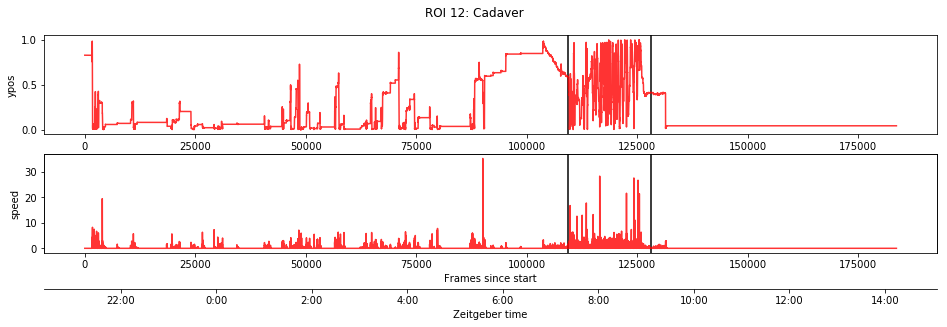

In [6]:
roi = 12
plt.figure(figsize=(16,4))
ax0, ax1 = plot_traj(roi, t_df, t_ed, ypos_color='red', spd_color='red')
ax2 = add_hr_x_axis(ax1, t_df)
ax2.set_xlabel('Zeitgeber time')
plt.show()

The first vertical black line marks manually-called $\tau$ time (onset of summiting behavior), and the second black line marks manually-called time of last movement. $\tau$ corresponds to a sudden flurry of activity with rapid movement, seen in the trajectory above as y movement covering all of the chamber and sustained high speed.

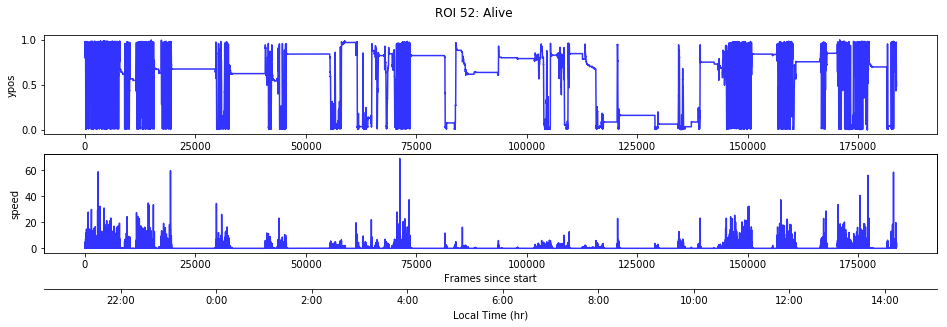

In [7]:
roi = 52
plt.figure(figsize=(16,4))
ax0, ax1 = plot_traj(roi, t_df, t_ed, ypos_color='blue', spd_color='blue')
ax2 = add_hr_x_axis(ax1, t_df)
#plt.savefig('ex_alive.png', bbox_inches='tight', dpi=300)
plt.show()

In this example of an alive fly, there is no ~1.5 hour sustained bout of activity corresponding to summiting. However, the first few hours resemble summiting pretty well, indicating that it's easy to have false positive summits!

### Looking at features from all data

Carolyn collected 15 boards worth of experiments from 3/22/2019 to 5/9/2019.

Let's look at some features across all the experiments:

In [8]:
summary_experiments_df = pd.read_csv('summary_table_experiments.csv', index_col=0)
summary_experiments_df

,experiment_name,date,nAlive,nNI,nCadaver,nTot
0,03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF...,03-22-2019,95,27,6,128
1,03-22-2019-18-37-18__Circadian_CsWF-BoardC3_MF...,03-22-2019,113,4,11,128
2,03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF...,03-23-2019,55,43,30,128
3,03-23-2019-18-35-30__Circadian_CsWF-BoardC3_MF...,03-23-2019,73,22,33,128
4,04-04-2019-18-59-55__Circadian_Cs_WF_exp_MF_Em...,04-04-2019,45,6,77,128
5,04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF...,04-05-2019,23,84,21,128
6,04-05-2019-21-17-24__Circadian_CsWF-BoardC14_M...,04-05-2019,13,74,41,128
7,04-06-2019-20-16-55__Circadian_CsWF-BoardC15_M...,04-06-2019,16,96,16,128
8,04-11-2019-19-32-45__Circadian_CsWF-BoardC12_M...,04-11-2019,24,73,31,128
9,04-15-2019-18-00-15__Circadian_CsWF-BoardC15_M...,04-15-2019,123,2,3,128


In [9]:
pd.DataFrame(summary_experiments_df.sum().iloc[2:], columns=['# examples over all experiments'])

,# examples over all experiments
nAlive,1018
nNI,469
nCadaver,433
nTot,1920


In [10]:
all_X = np.zeros((0, params['num_features']))
all_y = np.zeros((0,))

# list all data directories

all_dirs = [
    r'03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day3/',
    r'03-22-2019-18-37-18__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/',
    r'03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day4/',
    r'03-23-2019-18-35-30__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day4/',
    r'04-04-2019-18-59-55__Circadian_Cs_WF_exp_MF_Emuscae_1-128_Day1/',
    r'04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF_Emuscae_1-128_Day4/',
    r'04-05-2019-21-17-24__Circadian_CsWF-BoardC14_MF_Emuscae_1-128_Day4/',
    r'04-06-2019-20-16-55__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4/',
    r'04-11-2019-19-32-45__Circadian_CsWF-BoardC12_MF_Emuscae_1-128_Day4/',
    r'04-15-2019-18-00-15__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day3/',
    r'04-15-2019-18-03-17__Circadian_CsWF-BoardC2_MF_Emuscae_1-128_Day3/',
    r'04-16-2019-18-04-50__Circadian_CsWF-BoardC2_MF_Emuscae_1-128_Day4/',
    r'04-16-2019-18-10-44__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4/',
    r'04-21-2019-20-51-44__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/',
    r'05-09-2019-17-48-12__Circadian_Ethology-CsWF-BoardC10_MF_Emuscae_1-128_Day3/'    
]

all_dirs = [os.path.join(behavior_data_dir, x) for x in all_dirs]

In [11]:
params['do_continuous'] = False

In [12]:
# load in data into necessary form
log_cols = ['expmt', 'ROI', 'frame', 'y', 'type']
roi_log_df = pd.DataFrame(columns=log_cols)

all_X = np.zeros((0, params['num_features']))
all_y = np.zeros((0,))
t_eds = []; t_dfs = []

val_X = np.zeros((0, params['num_features']))
val_y = np.zeros((0,))
v_eds = []; v_dfs = []

print('Training data:')
for t_dir in all_dirs:
    print('\tReading in {}'.format(t_dir))
    # fix long filenames issue
    t_dir = '\\\\?\\'+os.path.abspath(t_dir)
    t_ed, t_df = get_data_from_exp_dir(t_dir)
    t_eds.append(t_ed); t_dfs.append(t_df)
    t_x, t_y, t_log = make_X_y_from_expmt(t_ed, t_df, params)
    mask = np.all(np.isnan(t_x), axis=1)
    t_x = t_x[~mask]; t_y = t_y[~mask]; t_log = t_log[~mask]
    expmt_log_df = pd.DataFrame(np.column_stack((
         [t_dir]*len(t_y), np.array(t_log), t_y, ['train']*len(t_y))), 
         columns=log_cols)
    all_X = np.concatenate((all_X, t_x))
    all_y = np.concatenate((all_y, t_y))
    roi_log_df = pd.concat((roi_log_df, expmt_log_df))

Training data:
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day3/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-22-2019-18-37-18__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day3/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/03-23-2019-18-35-30__Circadian_CsWF-BoardC3_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-04-2019-18-59-55__Circadian_Cs_WF_exp_MF_Emuscae_1-128_Day1/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-05-2019-21-14-39__Circadian_CsWF-BoardC4_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-05-2019-21-17-24__Circadian_CsWF-BoardC14_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 4 + Supp/04-06-2019-20-16-55__Circadian_CsWF-BoardC15_MF_Emuscae_1-128_Day4/
	Reading in ../../Data/Data by figure/Fig 

In [13]:
cm_train = plt.cm.get_cmap('RdYlBu_r')
cm_val = plt.cm.get_cmap('summer')
cols_train = [cm_train(x) for x in np.linspace(0, 1, len(all_dirs))]

### Time of summiting

Let's examine when summiting is called ($\tau$) for each cadaver in each experiment:

In [14]:
Ndirs = len(all_dirs)
all_taus = []
for i in range(Ndirs):
    taus = np.array(t_dfs[i]['tau_hr'].dropna())
    all_taus.append(taus)
mintau = min(np.concatenate(all_taus))
maxtau = max(np.concatenate(all_taus))

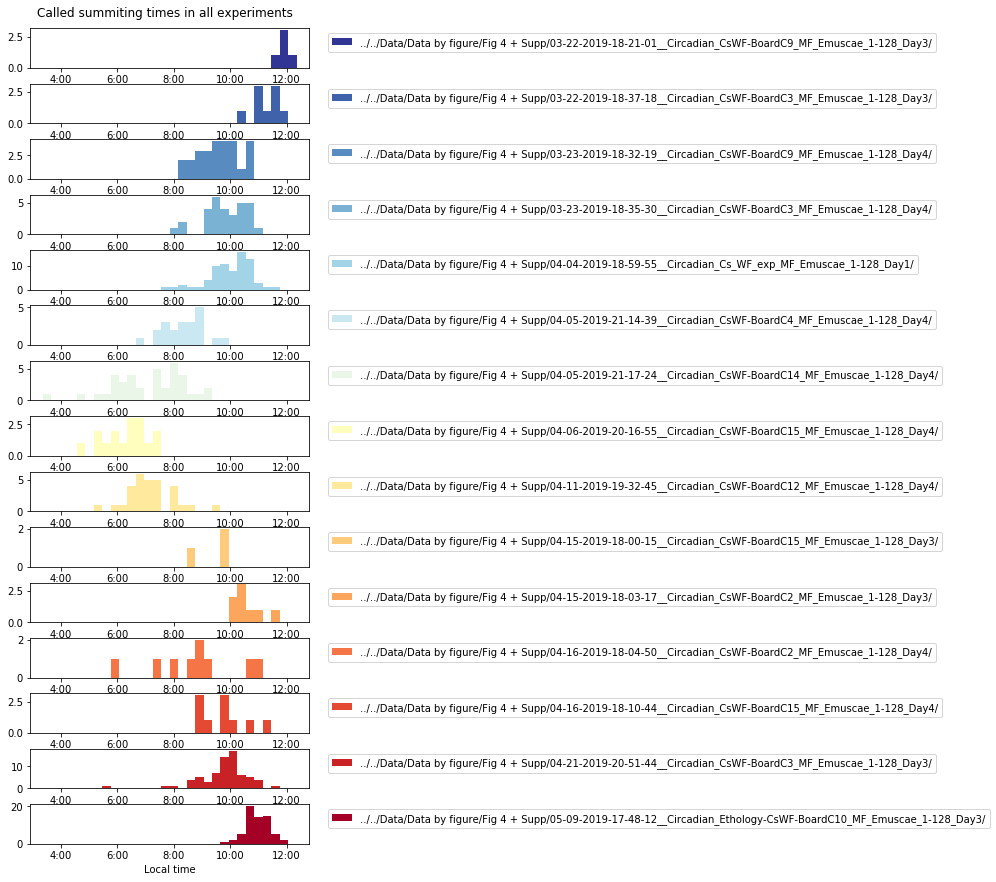

In [15]:
bins = np.arange(mintau, maxtau, 0.3)

plt.figure(figsize=(5,1*Ndirs))
plt.suptitle('Called summiting times in all experiments', y=0.9)
for i in range(Ndirs):
    ax1 = plt.subplot(Ndirs, 1, i+1)    
    ax1.hist(all_taus[i], bins=bins, color=cols_train[i], label=all_dirs[i])
    ax1.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel('Local time')
    xticks, xlocs = plt.xticks()
    ax1.set_xticklabels(['{:.0f}:00'.format(x % 24) for x in xticks])
plt.subplots_adjust(hspace=0.4)
plt.show()

Within each experiment, the times of summiting are clustered within an hour or two, but the distribution varies rather significantly across experiments. Thus, for training a model, it's very important to randomly split up examples from these experiments to capture the whole possible range.

At any rate, it is convenient that summiting occurs in the mornings (local time), which can help us throw away false positive summits seen early on in the tracking. 

The earliest time is at:

In [16]:
big_t_df = pd.concat(t_dfs + v_dfs)
np.round(np.nanmin(big_t_df['tau_hr']) % 24, 2)

3.35

No summiting events occur before around 3:20 AM. So, one could probably reliably start classification (or only start counting hits) around 3 AM.

### Determining summit duration
Let's get a sense for how long summiting lasts. For one experiment, if I plot the y position of the cadaver ROIs (aligning on their called summiting time), we see a bout of activity before cessation of movement:

../../Data/Data by figure/Fig 4 + Supp/03-22-2019-18-21-01__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day3/


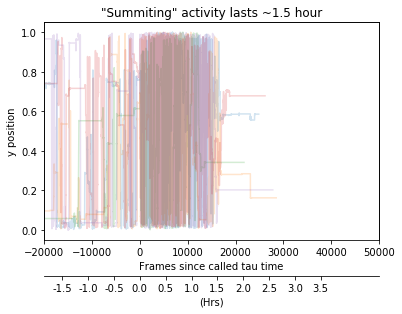

In [17]:
for i in [0]:
    print(all_dirs[i])
    
    t_df = t_dfs[i]; t_ed = t_eds[i]
    
    cad_ROIs = np.array(t_df[(t_df.Res == 'Cadaver') & (~np.isnan(t_df.Best_tau))].ROI.astype(int))
    tau_frames = np.array(t_df[t_df.ROI.isin(cad_ROIs)]['Best_tau'].astype(int))

    plt.figure()
    ax1 = plt.subplot(111)
    ax1.set_title('"Summiting" activity lasts ~1.5 hour')
    offset = 20000
    for i in range(len(cad_ROIs)):
        roi = cad_ROIs[i]
        yy = t_ed['ypos'][tau_frames[i]-offset:, roi-1]
        tt = np.arange(-offset, len(yy)-offset)
        ax1.plot(tt, yy, alpha=0.2)#, color='k')
    ax1.set_xlabel('Frames since called tau time')
    ax1.set_ylabel('y position')
    ax1.set_xlim(-offset, 50000)
    

    hr_min, hr_max = np.floor(np.array(ax1.get_xlim())/60/60/3)
    hr_labels = np.round(np.arange(hr_min, hr_max, 0.5), 2)
    hr_locs = [x* 60*60*3 for x in hr_labels]

    ax2 = ax1.twiny()
    ax2.set_xticks(hr_locs); ax2.set_xticklabels(hr_labels)
    ax2.xaxis.set_ticks_position('bottom'); ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 36))
    ax2.set_xlabel('(Hrs)')
    ax2.set_xlim(ax1.get_xlim())

    plt.show()

The flurry of activity looks like it lasts about 1.5 hours. To be more quantitative, let's have a better metric of summiting duration. Carolyn has manually called the start of summiting and the time of last movement for each collected cadaver. Taking the difference of these times as summiting duration, let's see what it looks like for each cadaver in each experiment:

In [18]:
all_durs = []
for i in range(Ndirs):
    t_df = t_dfs[i]
    durs = t_df['Last_mvmt'] - t_df['Best_tau']
    durs = durs[~np.isnan(durs)]
    all_durs.append(durs)

mindur = min(np.concatenate(all_durs))
maxdur = max(np.concatenate(all_durs))

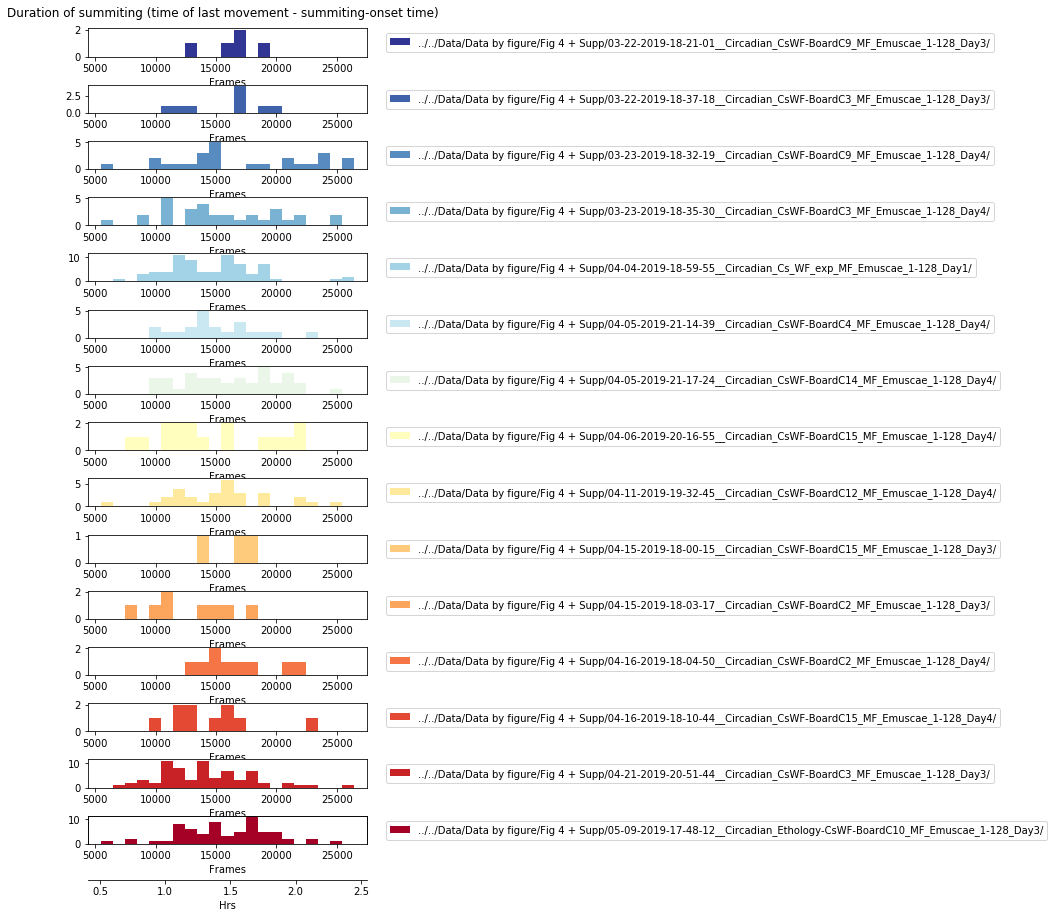

In [19]:
bins = np.arange(mindur, maxdur, 1000)
    
plt.figure(figsize=(5,1*Ndirs))
plt.suptitle('Duration of summiting (time of last movement - summiting-onset time)', y=0.9)
for i in range(Ndirs):
    ax1 = plt.subplot(Ndirs, 1, i+1)
    #plt.title('(Called time of last movement - called tau) in training data')
    ax1.hist(all_durs[i], bins=bins, color=cols_train[i], label=all_dirs[i])
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    ax1.set_xlabel('Frames')

hr_min, hr_max = np.round(np.array(ax1.get_xlim())/3/60/60 * 2.0) / 2.0
hr_labels = np.round(np.arange(hr_min, hr_max+0.01, 0.5), 2)
hr_locs = [x* 60*60*3 for x in hr_labels]
ax2 = ax1.twiny()
ax2.set_xticks(hr_locs); ax2.set_xticklabels(hr_labels)
ax2.xaxis.set_ticks_position('bottom'); ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 36))
ax2.set_xlabel('Hrs')
ax2.set_xlim(ax1.get_xlim())

plt.subplots_adjust(hspace=1)

plt.show()

The "summiting" length is centered around 1.5 hours, pretty consistent across experiments.

This is useful to keep in mind for determing the timeframes for "current" and "previous" activity. We won't have good results if it takes ~hours to reliably decide whether a sample is during summiting.

### Y position and speed

Now let's visualize the ypos and speed distributions for flies that don't succumb to the fungus ("alive"), and those that do ("cadavers", which have "pre-summiting", "during-summiting", and "post-summiting" states). On the left panel, I simply plot the y pos and speed of all frames in the training set, split up by state. For the right panel, I consider a moving average of 10 minutes (i.e. for "dur", I take the stretch of time an infected fly is undergoing summiting and I report the smoothed y pos and speed using a window of 10 minutes):

In [20]:
# go through each experiment, each ROI, and 
# store complete ypos/speed trajectories 
# corresponding to state (alive, pre, dur, post)

# initialize lists to hold trajectories
y_pres = []; spd_pres = []
y_durs = []; spd_durs = []
y_posts = []; spd_posts = []
y_alives = []; spd_alives = []

for i in range(len(all_dirs)):
    t_ed = t_eds[i]; t_df = t_dfs[i]
    for roi in t_df.ROI.astype(int):
        # label state
        state = t_df['Res'][roi-1]
        # get called tau (NaN if not called)
        tau_frame = t_df['Best_tau'][roi-1]
        # get called last movement (0 if not called)
        last_mvmt = t_df['Last_mvmt'][roi-1]
        # get y, spd trajectory
        y = t_ed['ypos'][:, roi-1]; spd = t_ed['speed'][:, roi-1]
        if state != 'NI': # skip NI's
            if state == 'Cadaver':
                if np.isnan(tau_frame):
                    # skip cadavers with no tau
                    pass
                else:
                    # store appropriately
                    tau_frame = tau_frame.astype(int)
                    last_mvmt = last_mvmt.astype(int)
                    y_pres.append(y[:tau_frame])
                    spd_pres.append(spd[:tau_frame])
                    y_durs.append(y[tau_frame:last_mvmt])
                    spd_durs.append(spd[tau_frame:last_mvmt])
                    ypost = y[last_mvmt:]
                    if len(ypost) > params['wl']:
                        y_posts.append(ypost)
                        spd_posts.append(spd[last_mvmt:])
            else: # if not cadaver, alive
                y_alives.append(y)
                spd_alives.append(spd)

In [21]:
# y_pres, for instance, is 
# [numROIsPreSummiting, respective_lengths],
# so we flatten it to make it 1-D
big_y_pres = np.concatenate(y_pres)
big_y_durs = np.concatenate(y_durs)
big_y_posts = np.concatenate(y_posts)
big_y_alives = np.concatenate(y_alives)
big_spd_pres = np.concatenate(spd_pres)
big_spd_durs = np.concatenate(spd_durs)
big_spd_posts = np.concatenate(spd_posts)
big_spd_alives = np.concatenate(spd_alives)

n_pres = len(big_y_pres)
n_durs = len(big_y_durs)
n_posts = len(big_y_posts)
n_alives = len(big_y_alives)

In [22]:
# do moving average based on window length wl set in params
mov_y_pres = np.concatenate([bn.move_mean(y, window=wl, min_count=1)[wl:-wl] for y in y_pres])
mov_y_durs = np.concatenate([bn.move_mean(y, window=wl, min_count=1)[wl:-wl] for y in y_durs])
mov_y_posts = np.concatenate([bn.move_mean(y, window=wl, min_count=1)[wl:-wl] for y in y_posts])
mov_y_alives = np.concatenate([bn.move_mean(y, window=wl, min_count=1)[wl:-wl] for y in y_alives])
mov_spd_pres = np.concatenate([bn.move_mean(s, window=wl, min_count=1)[wl:-wl] for s in spd_pres])
mov_spd_durs = np.concatenate([bn.move_mean(s, window=wl, min_count=1)[wl:-wl] for s in spd_durs])
mov_spd_posts = np.concatenate([bn.move_mean(s, window=wl, min_count=1)[wl:-wl] for s in spd_posts])
mov_spd_alives = np.concatenate([bn.move_mean(s, window=wl, min_count=1)[wl:-wl] for s in spd_alives])

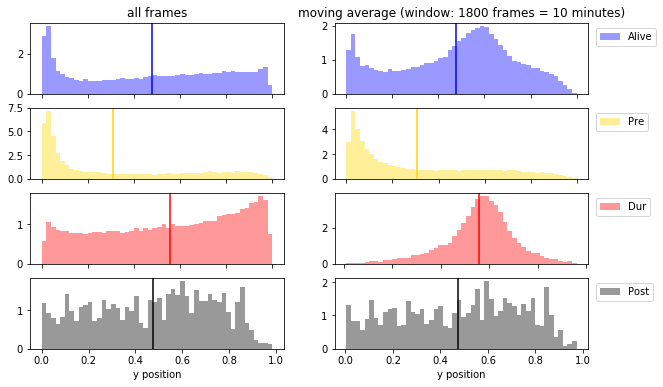

In [23]:
bins = 50

plt.figure(figsize=(10,6))

ax1 = plt.subplot(421)
plt.title('all frames')
plt.hist(big_y_alives, density=True, alpha=0.4, 
         bins=bins, color=state_colors['Alive'], label='Alive')#\n({})'.format(n_alives))
plt.axvline(np.mean(big_y_alives), color=state_colors['Alive'])
#plt.ylim(0, max_ht*1.05)
ax1.tick_params(labelbottom=False)

ax2 = plt.subplot(422)
plt.title('moving average (window: {} frames = {:.0f} minutes)'.format(wl, wl/3/60))
plt.hist(mov_y_alives, density=True, alpha=0.4, 
         bins=bins, color=state_colors['Alive'], label='Alive')#\n({})'.format(n_alives))
plt.axvline(np.mean(mov_y_alives), color=state_colors['Alive'])
#plt.ylim(0, max_ht*1.05)
ax2.tick_params(labelbottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))


ax3 = plt.subplot(423)
plt.hist(big_y_pres, density=True, alpha=0.4, 
         bins=bins, color=state_colors['pre'], label='Pre')#\n({})'.format(n_pres))
plt.axvline(np.mean(big_y_pres), color=state_colors['pre'])
#plt.ylim(0, max_ht*1.05)
ax3.tick_params(labelbottom=False)

ax4 = plt.subplot(424)
plt.hist(mov_y_pres, density=True, alpha=0.4, 
         bins=bins, color=state_colors['pre'], label='Pre')#\n({})'.format(n_pres))
plt.axvline(np.mean(mov_y_pres), color=state_colors['pre'])
#plt.ylim(0, max_ht*1.05)
ax4.tick_params(labelbottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))


ax5 = plt.subplot(425)
plt.hist(big_y_durs, density=True, alpha=0.4, 
         bins=bins, color=state_colors['dur'], label='Dur')#\n({})'.format(n_durs))
plt.axvline(np.mean(big_y_durs), color=state_colors['dur'])
#plt.ylim(0, max_ht*1.05)
ax5.tick_params(labelbottom=False)

ax6 = plt.subplot(426)
plt.hist(mov_y_durs, density=True, alpha=0.4, 
         bins=bins, color=state_colors['dur'], label='Dur')#\n({})'.format(n_durs))
plt.axvline(np.mean(big_y_durs), color=state_colors['dur'])
#plt.ylim(0, max_ht*1.05)
ax6.tick_params(labelbottom=False)
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))



ax7 = plt.subplot(427)
plt.hist(big_y_posts, density=True, alpha=0.4, 
         bins=bins, color=state_colors['post'], label='Post')#\n({})'.format(n_posts))
plt.axvline(np.mean(big_y_posts), color=state_colors['post'])
#plt.ylim(0, max_ht*1.05)
plt.xlabel('y position')

ax8 = plt.subplot(428)
plt.hist(mov_y_posts, density=True, alpha=0.4, 
         bins=bins, color=state_colors['post'], label='Post')#\n({})'.format(n_posts))
plt.axvline(np.mean(mov_y_posts), color=state_colors['post'])
#plt.ylim(0, max_ht*1.05)
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
plt.xlabel('y position')

plt.show()

(Vertical lines are means)

Looking at the left panel, alive flies appear rather similar to pre-summiting flies, though alive flies spend relatively less time at the bottom of the chamber. During- and post- summiting flies are rather uniform within the chamber.

Taking the moving average (right panel) reveals a little bit more information that could be useful for classification. The pre- flies still primarily occupy the bottom, and now are more visually distinct than the alive flies. In the alive flies, a peak emerges near 0.5 (indicating they're traveling up and down the chamber), possible to see by considering consecutive timepoints.. A similar peak is very distinct in the dur- flies. The post- flies remain rather uniform, since the vast majority within this stage are dead and fixed at one position (so taking a moving average doesn't change much from just looking at the raw frames).

Let's see this for speed too (plotted with log scale for a little more clarity):

In [24]:
def frac0(s, thresh_ub=0, thresh_lb=0):
    return np.sum((thresh_lb <= s) & (s <= thresh_ub)) / len(s)

def build_y_tab_from_t(tub, tlb):
    arr =  np.array([[frac0(big_y_alives, tub, tlb), frac0(mov_y_alives, tub, tlb)],
              [frac0(big_y_pres, tub, tlb), frac0(mov_y_pres, tub, tlb)],
              [frac0(big_y_durs, tub, tlb), frac0(mov_y_durs, tub, tlb)],
              [frac0(big_y_posts, tub, tlb), frac0(mov_y_posts, tub, tlb)]])
    return pd.DataFrame(arr, index=['Alive', 'pre', 'dur', 'post'], columns=['raw', 'movavg'])

def build_spd_tab_from_t(tub, tlb):
    arr =  np.array([[frac0(big_spd_alives, tub, tlb), frac0(mov_spd_alives, tub, tlb)],
              [frac0(big_spd_pres, tub, tlb), frac0(mov_spd_pres, tub, tlb)],
              [frac0(big_spd_durs, tub, tlb), frac0(mov_spd_durs, tub, tlb)],
              [frac0(big_spd_posts, tub, tlb), frac0(mov_spd_posts, tub, tlb)]])
    return pd.DataFrame(arr, index=['Alive', 'pre', 'dur', 'post'], columns=['raw', 'movavg'])

In [25]:
y_t01 = build_y_tab_from_t(0.1, 0)
y_t09 = build_y_tab_from_t(1, 0.9)
y_tmid = build_y_tab_from_t(0.6, 0.4)
spd_te5 = build_spd_tab_from_t(1e-5, 0)
spd_t1 = build_spd_tab_from_t(300, 1)

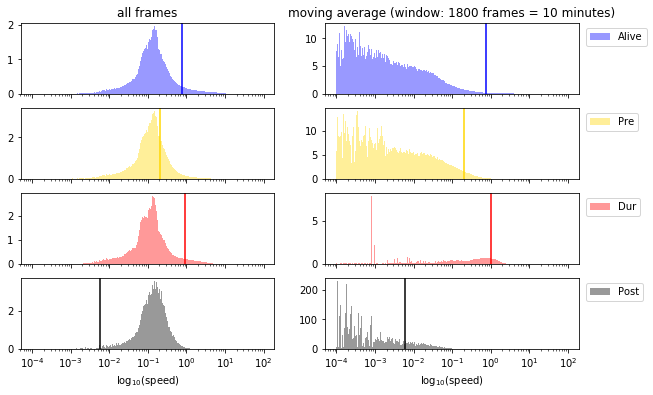

In [26]:
bins1=10**np.arange(-3, 1.1, 0.025)
bins2=10**np.arange(-4, 2, 0.025)

plt.figure(figsize=(10,6))

ax1 = plt.subplot(421)
plt.title('all frames')
plt.hist(big_spd_alives, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['Alive'], label='Alive')#\n({})'.format(n_alives))
plt.axvline(np.mean(big_spd_alives), color=state_colors['Alive'])
ax1.tick_params(labelbottom=False)   
plt.xscale('log')

ax2 = plt.subplot(422)
plt.title('moving average (window: {} frames = {:.0f} minutes)'.format(wl, wl/3/60))
plt.hist(mov_spd_alives, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['Alive'], label='Alive')#\n({})'.format(n_alives))
plt.axvline(np.mean(mov_spd_alives), color=state_colors['Alive'])
ax2.tick_params(labelbottom=False)   
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
plt.xscale('log')


ax3 = plt.subplot(423)
plt.hist(big_spd_pres, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['pre'], label='Pre')#\n({})'.format(n_pres))
plt.axvline(np.mean(big_spd_pres), color=state_colors['pre'])
ax3.tick_params(labelbottom=False)   
plt.xscale('log')

ax4 = plt.subplot(424)
plt.hist(mov_spd_pres, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['pre'], label='Pre')#\n({})'.format(n_pres))
plt.axvline(np.mean(mov_spd_pres), color=state_colors['pre'])
ax4.tick_params(labelbottom=False)   
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
plt.xscale('log')


ax5 = plt.subplot(425)
plt.hist(big_spd_durs, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['dur'], label='Dur')#\n({})'.format(n_durs))
plt.axvline(np.mean(big_spd_durs), color=state_colors['dur'])
ax5.tick_params(labelbottom=False)   
plt.xscale('log')

ax6 = plt.subplot(426)
plt.hist(mov_spd_durs, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['dur'], label='Dur')#\n({})'.format(n_durs))
plt.axvline(np.mean(mov_spd_durs), color=state_colors['dur'])
ax6.tick_params(labelbottom=False)   
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
plt.xscale('log')


ax7 = plt.subplot(427)
plt.hist(big_spd_posts, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['post'], label='Post')#\n({})'.format(n_posts))
plt.axvline(np.mean(big_spd_posts), color=state_colors['post'])
plt.xscale('log')
plt.xlabel('$\log_{10}$'+'(speed)')

ax8 = plt.subplot(428)
plt.hist(mov_spd_posts, density=True, alpha=0.4, 
         bins=bins2, color=state_colors['post'], label='Post')#\n({})'.format(n_posts))
plt.axvline(np.mean(mov_spd_posts), color=state_colors['post'])
plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
plt.xscale('log')
plt.xlabel('$\log_{10}$'+'(speed)')

plt.show()

Differences are very slight when looking at all frames independently, but taking the moving average allows dur- flies to really stand out (they're moving constantly during summiting, so there's likely few consecutive stretches of 0's that are otherwise present in the other regimes)

Overall, this suggests that taking an average over a window of time is more informative than single frames alone. 

Looking at quantiles of these distributions tells the same story but is another view:

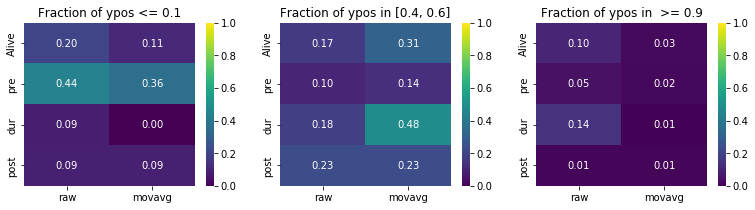

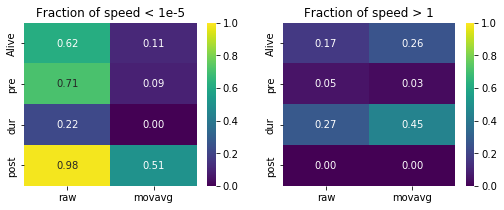

In [27]:
plt.figure(figsize=(13,3))
plt.subplot(131)
plt.title('Fraction of ypos <= 0.1')
sns.heatmap(y_t01, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.subplot(132)
plt.title('Fraction of ypos in [0.4, 0.6]')
sns.heatmap(y_tmid, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.subplot(133)
plt.title('Fraction of ypos in  >= 0.9')
sns.heatmap(y_t09, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.show()

plt.figure(figsize=(8.5,3))
plt.subplot(121)
plt.title('Fraction of speed < 1e-5')
sns.heatmap(spd_te5, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.subplot(122)
plt.title('Fraction of speed > 1')
sns.heatmap(spd_t1, annot=True, cmap='viridis', fmt='.2f', vmin=0, vmax=1)
plt.show()

Again we see that the moving average might be more useful for classification. For instance, the fraction of frame y positions in the middle of the chamber (0.4-0.6) are rather similar across classes, but taking a moving average really distinguishes the dur- samples. 

These class count differences also give support for cutoff-based methods like random forests.

A tree in a random forest scans the features of the data and tries to find a cutoff condition in one of the features that splits the data into two internally-similar bins. For instance, if we had a feature that was "average speed in the last 10 minutes", a cutoff of 1e-5 for speed would be great for distinguishing dur- flies from all others (since none have lower than 1e-5 speed).

## Visualizing frame selection for "previous" and "current" behavior

Let's see what "previous" (green) and "current" (violet) behavior actually looks like, if we collect 100 current frames (sampled across 10 minutes) and 80 previous frames (sampled across entire timeseries, spaced logarithmically). 

We have the entire trajectory in this example, but what I want to show here is what the ypos/speed features look like at different points in time (i.e. the latest "current" behavior frame). 

The top panel shows the motion data in black, and the overlaid green/violet bars are the frames representing previous and current behavior. The histograms on the bottom are the respective features for the previous/current frames, either by taking the frames as they are or by looking at the average over a window of time.

The examples comprise 1 pre-, 2 during-, and 1 post-summiting:

In [28]:
t_dir = os.path.join(behavior_data_dir, '03-23-2019-18-32-19__Circadian_CsWF-BoardC9_MF_Emuscae_1-128_Day4/')
t_ed, t_df = get_data_from_exp_dir(t_dir)
roi = 128

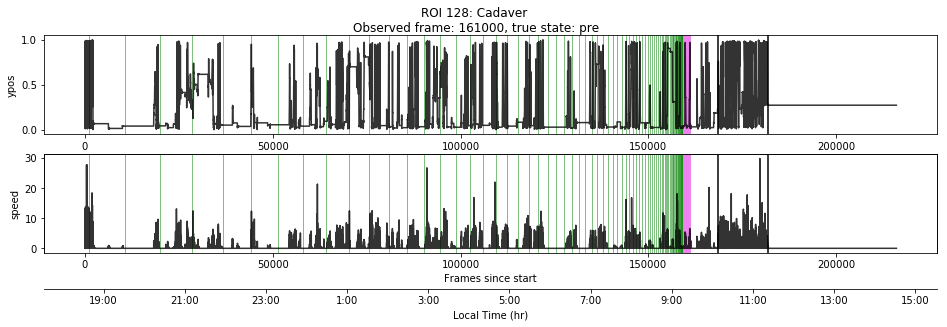

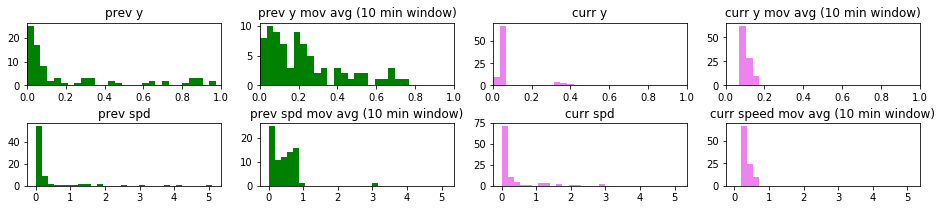

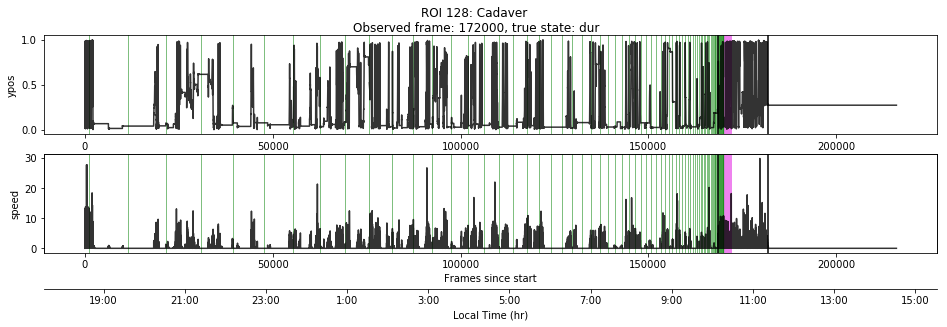

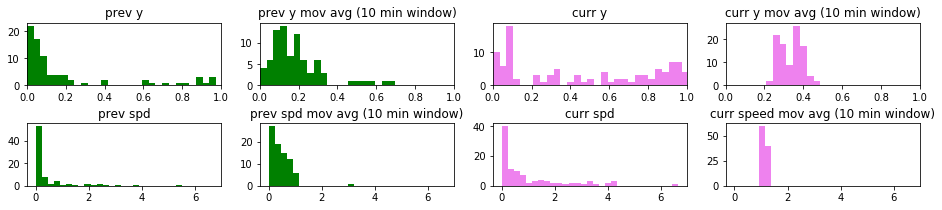

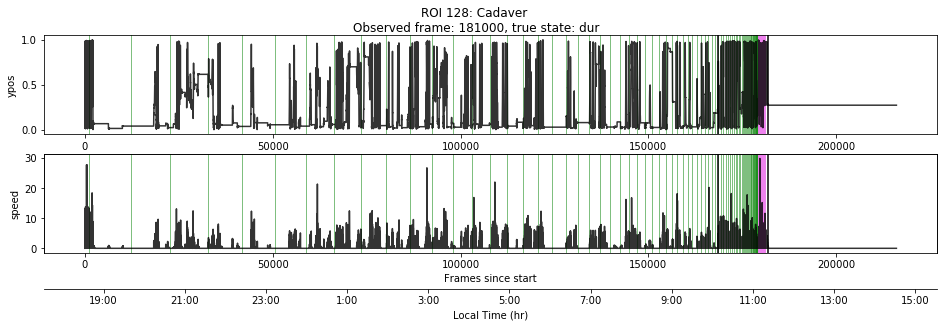

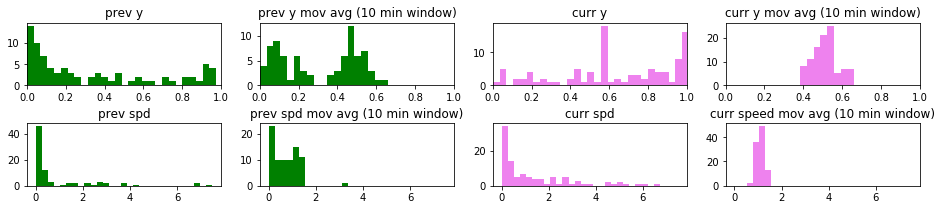

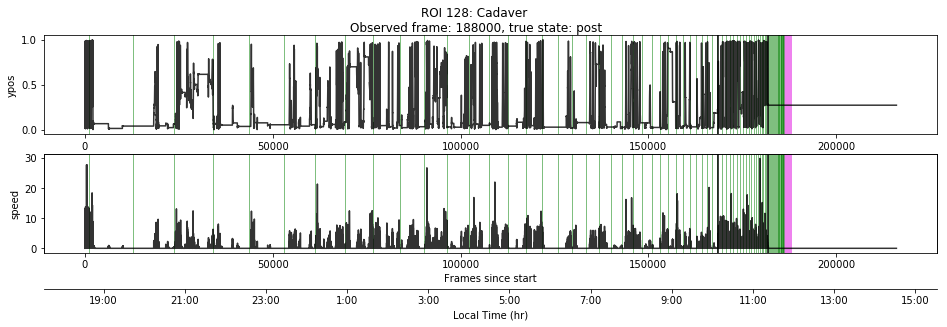

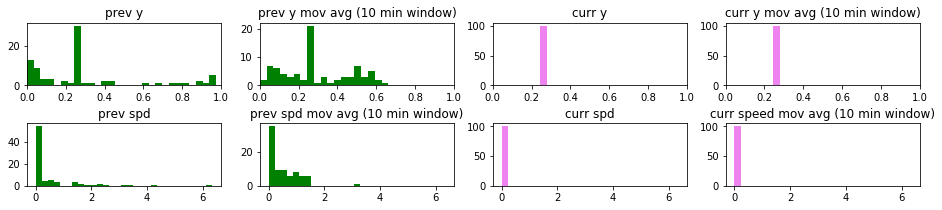

In [29]:
fs = [161000, 172000, 181000, 188000]

prev_color = 'green'
curr_color = 'violet'

for fr in fs:

    base_frame = fr

    # get relevant frames
    prev_frames, curr_frames = get_frames(base_frame, params)
    grab_frames = np.concatenate((prev_frames, curr_frames))
    
    # get raw data
    ypos = t_ed['ypos'][:, roi-1] 
    spd = t_ed['speed'][:, roi-1]

    # make X, y
    X_ex = make_X_from_frames_roi(base_frame, grab_frames, ypos, spd, t_ed)
    y_ex = make_y_from_frames_roi(curr_frames, roi, t_ed, t_df, params)
    
    plt.figure(figsize=(16,4))
    ax0, ax1 = plot_traj(roi, t_df, t_ed, 
             frame_sets = [prev_frames, curr_frames],
             frame_cols = [prev_color, curr_color],
             frame_sets_bottom = [prev_frames, curr_frames],
             frame_cols_bottom = [prev_color, curr_color],
             title='\nObserved frame: {}, true state: {}'.format(base_frame, y_ex))
    ax2 = add_hr_x_axis(ax1, t_df)
    plt.show()
    
    plt.figure(figsize=(16,3))
    bins = np.linspace(0, 1.01, 30)
    plt.subplot(241)
    plt.title('prev y')
    plt.hist(t_ed['ypos'][prev_frames, roi-1], bins=bins, color=prev_color)
    plt.xlim(0, 1)
    plt.subplot(242)
    plt.title('prev y mov avg ({:.0f} min window)'.format(wl/3/60))
    plt.hist(bn.move_mean(t_ed['ypos'][:, roi-1], window=wl, min_count=1)[prev_frames], 
             bins=bins, color=prev_color)
    plt.xlim(0, 1)
    plt.subplot(243)
    plt.title('curr y')
    plt.hist(t_ed['ypos'][curr_frames, roi-1], bins=bins, color=curr_color)
    plt.xlim(0, 1)
    plt.subplot(244)
    plt.title('curr y mov avg ({:.0f} min window)'.format(wl/3/60))
    plt.hist(bn.move_mean(t_ed['ypos'][:, roi-1], window=wl, min_count=1)[curr_frames], 
             bins=bins, color=curr_color)
    plt.xlim(0, 1)
    
    plt.subplots_adjust(hspace=0.6)
   
    p1 = t_ed['speed'][prev_frames, roi-1];
    p2 = bn.move_mean(t_ed['speed'][:, roi-1], window=wl, min_count=1)[prev_frames]
    p3 = t_ed['speed'][curr_frames, roi-1]
    p4 = bn.move_mean(t_ed['speed'][:, roi-1], window=wl, min_count=1)[curr_frames]
    slb = min(min(p1), min(p2), min(p3), min(p4))
    sub = max(max(p1), max(p2), max(p3), max(p4))
    bins2 = np.linspace(slb, sub, 30)
    
    plt.subplot(245)
    plt.title('prev spd')
    plt.hist(p1, bins=bins2, color=prev_color)
    #plt.xlim(0, 1)
    plt.subplot(246)
    plt.title('prev spd mov avg ({:.0f} min window)'.format(wl/3/60))
    plt.hist(p2, bins=bins2, color=prev_color)
    #plt.xlim(0, 1)
    plt.subplot(247)
    plt.title('curr spd')
    plt.hist(p3, bins=bins2, color=curr_color)
    #plt.xlim(0, 1)
    plt.subplot(248)
    plt.title('curr speed mov avg ({:.0f} min window)'.format(wl/3/60))
    plt.hist(p4, bins=bins2, color=curr_color)
    #plt.xlim(0, 1)
    plt.show()

When comparing the current to previous histograms, taking an average over a 10 minute window does appear to make them more distinct (especially position). 

## Visualizing processed data $X$:

Now let's revisit the data matrix setup from the beginning and see what a full $X_i$ looks like:

\begin{equation}
X_i = \bigg(\underbrace{time}_{current},\underbrace{ypos, \dots, ypos}_{previous},\underbrace{ypos, \dots, ypos}_{current},\underbrace{speed, \dots, speed}_{previous},\underbrace{speed, \dots, speed}_{current} \bigg)
\end{equation}

If we don't do the moving average:

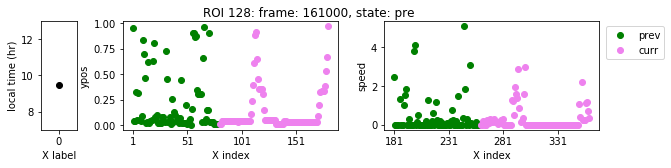

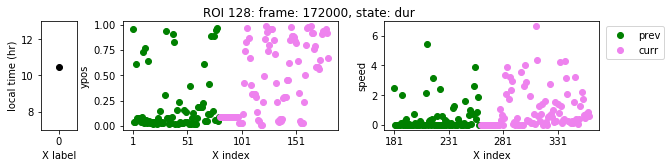

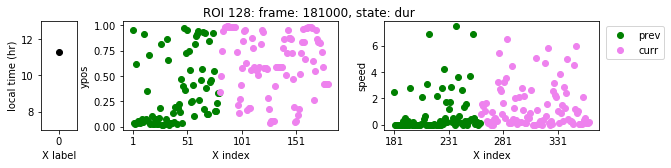

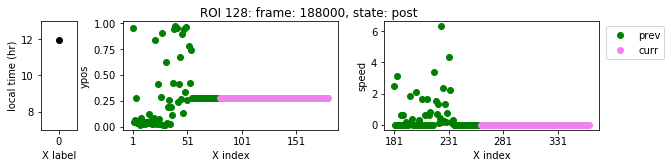

In [30]:
for fr in fs:

    base_frame = fr
    
    # get relevant frames
    prev_frames, curr_frames = get_frames(base_frame, params)
    grab_frames = np.concatenate((prev_frames, curr_frames))

    # get raw data
    ypos = t_ed['ypos'][:, roi-1] 
    spd = t_ed['speed'][:, roi-1]

    
    # make X, y
    X = make_X_from_frames_roi(base_frame, grab_frames, ypos, spd, t_ed)
    y = make_y_from_frames_roi(curr_frames, roi, t_ed, t_df, params)
    

    # get indices
    t = X[0]
    ypos_prev = X[params['i_ypos_prev']]; ypos_curr = X[params['i_ypos_curr']]
    spd_prev = X[params['i_spd_prev']]; spd_curr = X[params['i_spd_curr']]
    
    plt.figure(figsize=(10,2))
    plt.suptitle('ROI {}: frame: {}, state: {} '.format(roi, base_frame, y))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,6,6])
    plt.subplot(gs[0])
    plt.plot(0, t % 24, 'o', color='k')
    plt.ylim(7, 13)
    plt.xticks([0], [0])
    plt.xlabel('X label')
    plt.ylabel('local time (hr)')
    plt.subplot(gs[1])
    plt.plot(1+np.arange(pn), ypos_prev, 
             'o', color=prev_color)
    plt.plot(1+pn+np.arange(cn), ypos_curr, 
             'o', color=curr_color)
    plt.xticks(np.arange(1,1+pn+cn, 50), np.arange(1,1+pn+cn, 50))
    plt.ylabel('ypos')
    plt.xlabel('X index')
    plt.subplot(gs[2])
    plt.plot(1+pn+cn+np.arange(pn), spd_prev, 
             'o', color=prev_color, label='prev')
    plt.plot(1+2*pn+cn+np.arange(cn), spd_curr, 
             'o', color=curr_color, label='curr')
    plt.xticks(np.arange(1+pn+cn,1+2*pn+2*cn, 50), np.arange(1+pn+cn,1+2*pn+2*cn, 50))
    plt.ylabel('speed')
    plt.xlabel('X index')
    plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

And if we do the moving average:

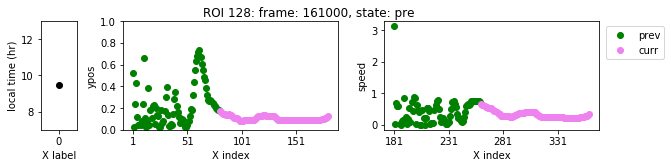

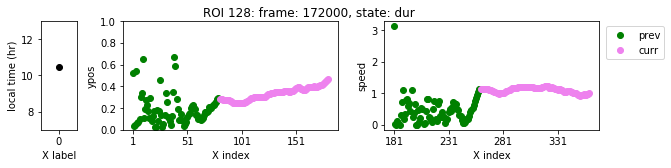

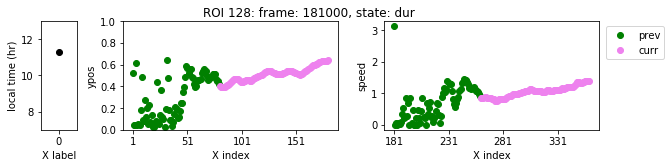

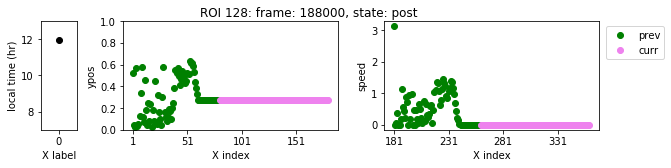

In [31]:
for fr in fs:

    base_frame = fr
    
    # get relevant frames
    prev_frames, curr_frames = get_frames(base_frame, params)
    grab_frames = np.concatenate((prev_frames, curr_frames))

    # get raw data
    ypos = t_ed['ypos'][:, roi-1] 
    spd = t_ed['speed'][:, roi-1]
    if params['do_mov_avg']:
        ypos = bn.move_mean(ypos, window=params['wl'], min_count=1)
        spd = bn.move_mean(spd, window=params['wl'], min_count=1)
        
    # make X, y
    X = make_X_from_frames_roi(base_frame, grab_frames, ypos, spd, t_ed)
    y = make_y_from_frames_roi(curr_frames, roi, t_ed, t_df, params)
    

    # get indices
    t = X[0]
    ypos_prev = X[params['i_ypos_prev']]; ypos_curr = X[params['i_ypos_curr']]
    spd_prev = X[params['i_spd_prev']]; spd_curr = X[params['i_spd_curr']]
    
    plt.figure(figsize=(10,2))
    plt.suptitle('ROI {}: frame: {}, state: {} '.format(roi, base_frame, y))
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,6,6])
    plt.subplot(gs[0])
    plt.plot(0, t % 24, 'o', color='k')
    plt.ylim(7, 13)
    plt.xticks([0], [0])
    plt.xlabel('X label')
    plt.ylabel('local time (hr)')
    plt.subplot(gs[1])
    plt.plot(1+np.arange(pn), ypos_prev, 
             'o', color=prev_color)
    plt.plot(1+pn+np.arange(cn), ypos_curr, 
             'o', color=curr_color)
    plt.xticks(np.arange(1,1+pn+cn, 50), np.arange(1,1+pn+cn, 50))
    plt.ylabel('ypos')
    plt.ylim(0, 1)
    plt.xlabel('X index')
    
    
    plt.subplot(gs[2])
    plt.plot(1+pn+cn+np.arange(pn), spd_prev,#np.log(spd_prev),
             'o', color=prev_color, label='prev')
    plt.plot(1+2*pn+cn+np.arange(cn), spd_curr,#np.log(spd_curr), 
             'o', color=curr_color, label='curr')
    plt.xticks(np.arange(1+pn+cn,1+2*pn+2*cn, 50), np.arange(1+pn+cn,1+2*pn+2*cn, 50))
    plt.ylabel('speed')
    plt.xlabel('X index')
    plt.legend(loc='upper left', bbox_to_anchor=(1.01,1))
    plt.subplots_adjust(wspace=0.3)
    plt.show()

At the end of the day, these vectors are what the classifier will "see" and make decisions on.

Let's see what these vectors look like in all of the data (it's a little easier for us to see differences in log speed, but the data vectors fed into the classifier are not log):

In [32]:
all_alives = np.where(all_y == 'Alive')[0]; n_all_alive = len(all_alives)
all_pres = np.where(all_y == 'pre')[0]; n_all_pre = len(all_pres)
all_durs = np.where(all_y == 'dur')[0]; n_all_dur = len(all_durs)
all_posts = np.where(all_y == 'post')[0]; n_all_post = len(all_posts)
sub_alive = all_X[all_alives]
sub_pre = all_X[all_pres]
sub_dur = all_X[all_durs]
sub_post = all_X[all_posts]

In [33]:
from matplotlib.ticker import MaxNLocator

dic_state_names = {
    'Alive': 'non-summiting',
    'pre': 'pre-summiting',
    'dur': 'during summiting',
    'post': 'post-summiting'
}

def plot_feature_vec(sub_df, state, gs, plotnum, params,
        ntoplot=200, alph=3,
        min_ht = -0.04, max_ht = 1.04, 
        min_spd = -12, max_spd = 1,
        min_t = 27, max_t = 39):
    '''
    
    
    '''
    
    np.random.seed(1234)

    pn = params['NPREV']; cn = params['NCURR']
    which_to_plot = np.random.randint(0, len(sub_df), ntoplot)
    alph /= ntoplot
    
    ax1 = plt.subplot(gs[plotnum])
    #plt.title('{} time'.format(state))
    ax1.hist(sub_df[which_to_plot, 0], bins=40, orientation='horizontal', 
             color=state_colors[state])
    ax1.set_ylim(min_t, max_t)
    
    plt.xticks([], []) 
    
    
    ax2 = plt.subplot(gs[plotnum+1])
    
    ax2.set_ylim(min_ht, max_ht)
    ax2.plot(1+np.arange(pn), sub_df[which_to_plot, 1:(pn+1)].T, 
             'o', markeredgewidth=0, alpha=alph, color=state_colors[state])
    ax2.plot(1+pn+np.arange(cn), sub_df[which_to_plot, (pn+1):(1+pn+cn)].T, 
             'o', markeredgewidth=0, alpha=alph, color=state_colors[state])
    ax2.axvline(1+pn, linestyle='--', color='gray')
    #fig_ht = ax2.get_ylim()[1] - ax2.get_ylim()[0]
    fig_ht = max_ht - min_ht
    ax2.text(pn/2, min_ht-0.03*fig_ht, 'historical',
             horizontalalignment='center', verticalalignment='top')
    ax2.text(1+pn+cn/2, min_ht-0.03*fig_ht, 'current',
             horizontalalignment='center', verticalalignment='top')
    plt.xticks([], [])  
   
    ax3 = plt.subplot(gs[plotnum+2])
    #plt.title('{} speed (log)'.format(state))
    ax3.set_ylim(min_spd, max_spd)
    dat1 = sub_df[which_to_plot, (pn+cn+1):(1+2*pn+cn)].T
    dat1[dat1 <= 0] = np.nan
    ax3.plot(1+np.arange(pn), np.log10(dat1),
             'o', markeredgewidth=0, alpha=alph, color=state_colors[state])
    dat2 = sub_df[which_to_plot, (2*pn+cn+1):].T
    dat2[dat2 <= 0] = np.nan
    ax3.plot(1+pn+np.arange(cn), np.log10(dat2), 
             'o', markeredgewidth=0, alpha=alph, color=state_colors[state])
    ax3.axvline(1+pn, linestyle='--', color='gray')
    #fig_ht = ax2.get_ylim()[1] - ax2.get_ylim()[0]
    fig_ht = max_spd - min_spd
    ax3.text(pn/2, min_spd-0.03*fig_ht, 'historical',
             horizontalalignment='center', verticalalignment='top')
    ax3.text(1+pn+cn/2, min_spd-0.03*fig_ht, 'current',
             horizontalalignment='center', verticalalignment='top')
    plt.xticks([], [])    
    
    ax1.set_ylabel('time')
    ax2.set_ylabel('y position')
    ax3.set_ylabel(r'$\log_{10}$ speed', labelpad=0)

    plt.subplots_adjust(wspace=0.4)
    
    ax2.set_title('{}'.format(dic_state_names[state]), x=0.85, y=1.05, fontsize=13)
    
    ax3.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    return ax1, ax2, ax3

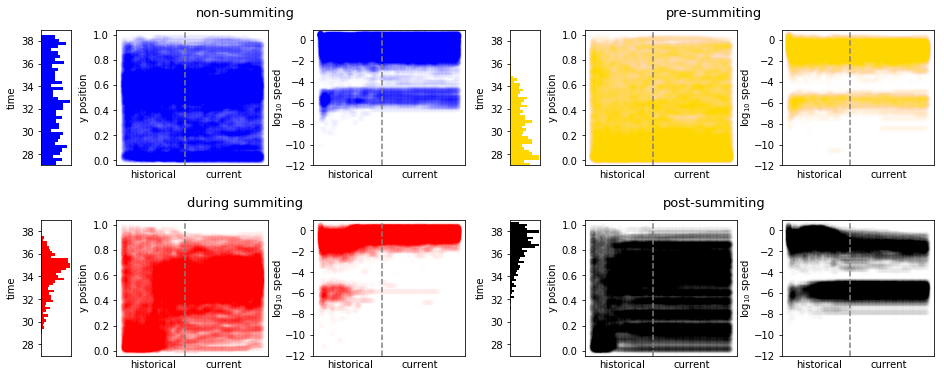

In [34]:
ntoplot = 500
alph = 5

plt.figure(figsize=(16,6))
gs = gridspec.GridSpec(2, 7, width_ratios=[1,5,5,0,1,5,5])
gs = gridspec.GridSpec(2, 6, width_ratios=[1,5,5,1,5,5])
ax1, ax2, ax3 = plot_feature_vec(sub_alive, 'Alive', gs, 0, params, ntoplot=ntoplot, alph=alph)
ax4, ax5, ax6 = plot_feature_vec(sub_pre, 'pre', gs, 3, params, ntoplot=ntoplot, alph=alph)
ax7, ax8, ax9 = plot_feature_vec(sub_dur, 'dur', gs, 6, params, ntoplot=ntoplot, alph=alph)
ax10, ax11, ax12 = plot_feature_vec(sub_post, 'post', gs, 9, params, ntoplot=ntoplot, alph=alph)
plt.subplots_adjust(hspace=0.4)
plt.show()

We can see that the "during" and "post" features are quite distinct. The speed distribution is especially telling -- there is sustained high speed in the "dur" flies and sustained low speed in the "post" flies. The "alive" and "pre" flies appear similar, but "pre" flies do occupy the bottom of the chamber more often.

Now we're ready to use such data vectors to train a classifier so that later it can classify unseen data. Next stop: `train_random_forest.ipynb`.